In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import shap
from sklearn.feature_selection import RFECV
import scipy.stats as stats

# Ignore warnings for cleaner output
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv("cardio_train.csv", sep=";")

# Display basic info
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB
None
   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140  

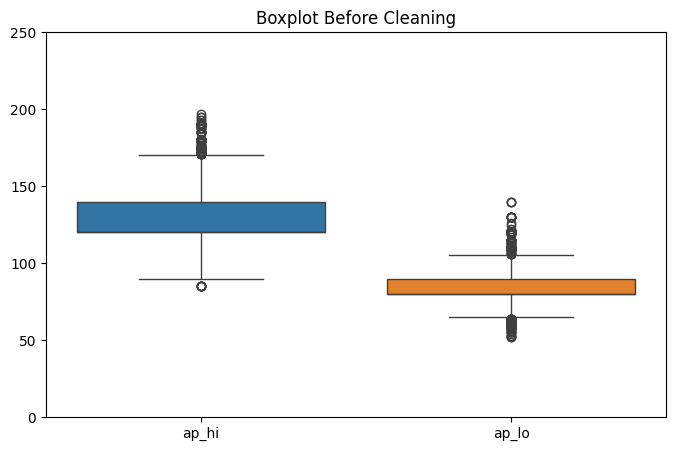

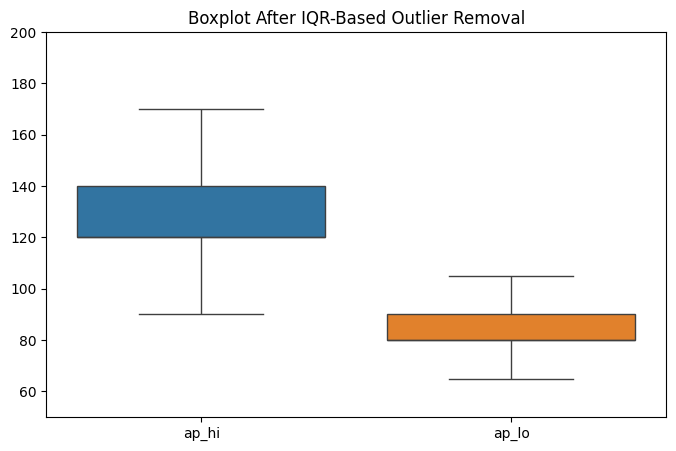

In [3]:
# --- Initial boxplot (before any cleaning) ---
plt.figure(figsize=(8, 5))
sns.boxplot(data=df[['ap_hi', 'ap_lo']])
plt.title("Boxplot Before Cleaning")
plt.ylim(0, 250)
plt.show()

# --- Remove unrealistic values ---
df = df[(df['ap_hi'] > 80) & (df['ap_hi'] < 200)]
df = df[(df['ap_lo'] > 50) & (df['ap_lo'] < 150)]
df = df[df['ap_hi'] > df['ap_lo']]

# --- IQR-based outlier removal ---
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = remove_outliers_iqr(df, 'ap_hi')
df = remove_outliers_iqr(df, 'ap_lo')

# --- Boxplot after full cleaning ---
plt.figure(figsize=(8, 5))
sns.boxplot(data=df[['ap_hi', 'ap_lo']])
plt.title("Boxplot After IQR-Based Outlier Removal")
plt.ylim(50, 200)
plt.show()


In [4]:
# --- Scale numerical features ---
scaler = StandardScaler()
numerical_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# --- Display cleaned and scaled dataset summary ---
print(df.describe())

                 id           age        gender        height        weight  \
count  64498.000000  6.449800e+04  64498.000000  6.449800e+04  6.449800e+04   
mean   49967.088762 -6.996584e-16      1.351871 -1.278576e-15  1.062322e-15   
std    28856.264796  1.000008e+00      0.477558  1.000008e+00  1.000008e+00   
min        0.000000 -3.511194e+00      1.000000 -1.343372e+01 -4.473624e+00   
25%    24924.250000 -7.206978e-01      1.000000 -6.697162e-01 -6.548543e-01   
50%    50011.000000  9.111251e-02      1.000000  6.666869e-02 -1.598286e-01   
75%    74879.750000  7.528437e-01      2.000000  6.803228e-01  5.473508e-01   
max    99999.000000  1.716767e+00      2.000000  1.049879e+01  8.892069e+00   

              ap_hi         ap_lo   cholesterol          gluc         smoke  \
count  6.449800e+04  6.449800e+04  64498.000000  64498.000000  64498.000000   
mean   2.795990e-16  1.733998e-16      1.364275      1.225666      0.087615   
std    1.000008e+00  1.000008e+00      0.680284    

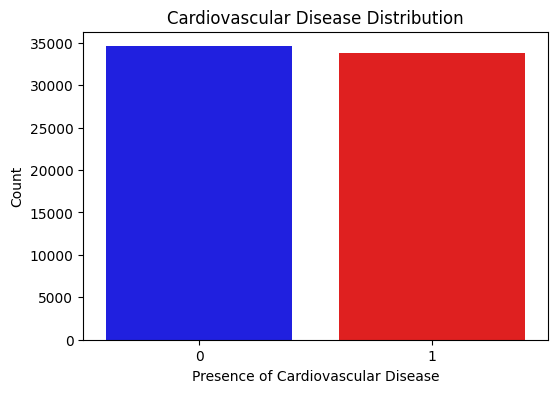

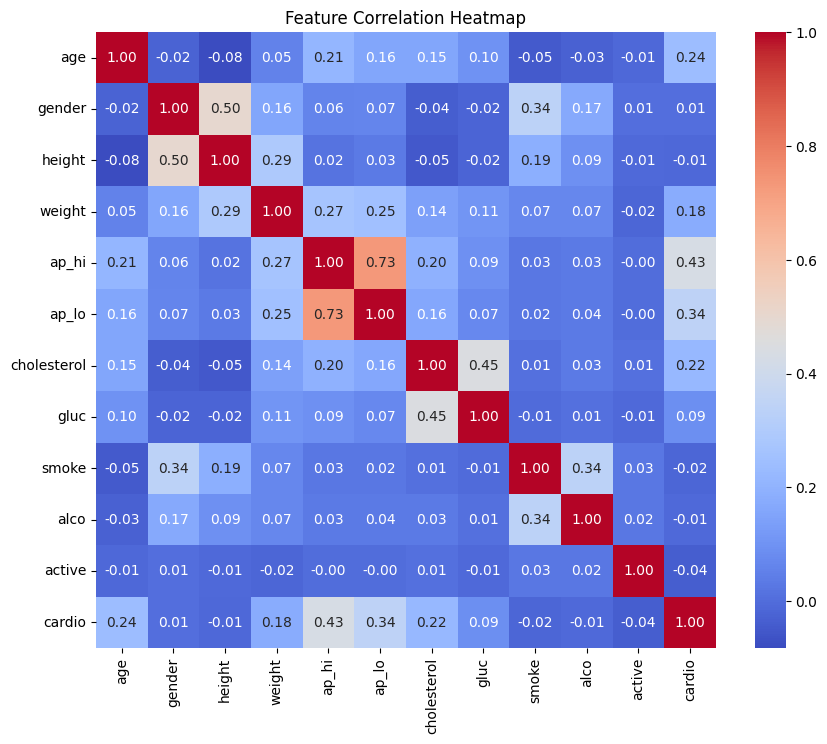

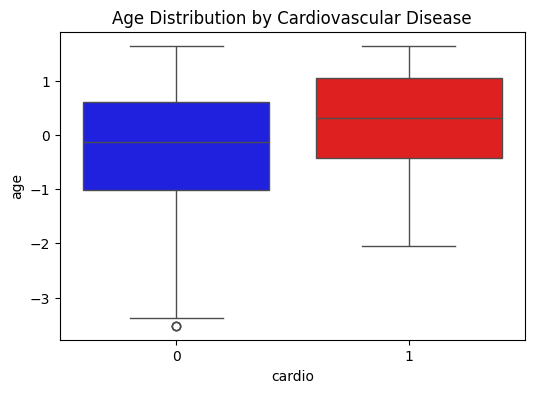

In [ ]:
# Visualize Cardiovascular Disease Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df['cardio'], palette=['blue', 'red'])
plt.title("Cardiovascular Disease Distribution")
plt.xlabel("Presence of Cardiovascular Disease")
plt.ylabel("Count")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Boxplot of Age vs. Cardiovascular Disease
plt.figure(figsize=(6,4))
sns.boxplot(x=df['cardio'], y=df['age'], palette=['blue', 'red'])
plt.title("Age Distribution by Cardiovascular Disease")
plt.show()


100%|===================| 9982/10000 [06:43<00:00]       

<Figure size 1000x600 with 0 Axes>

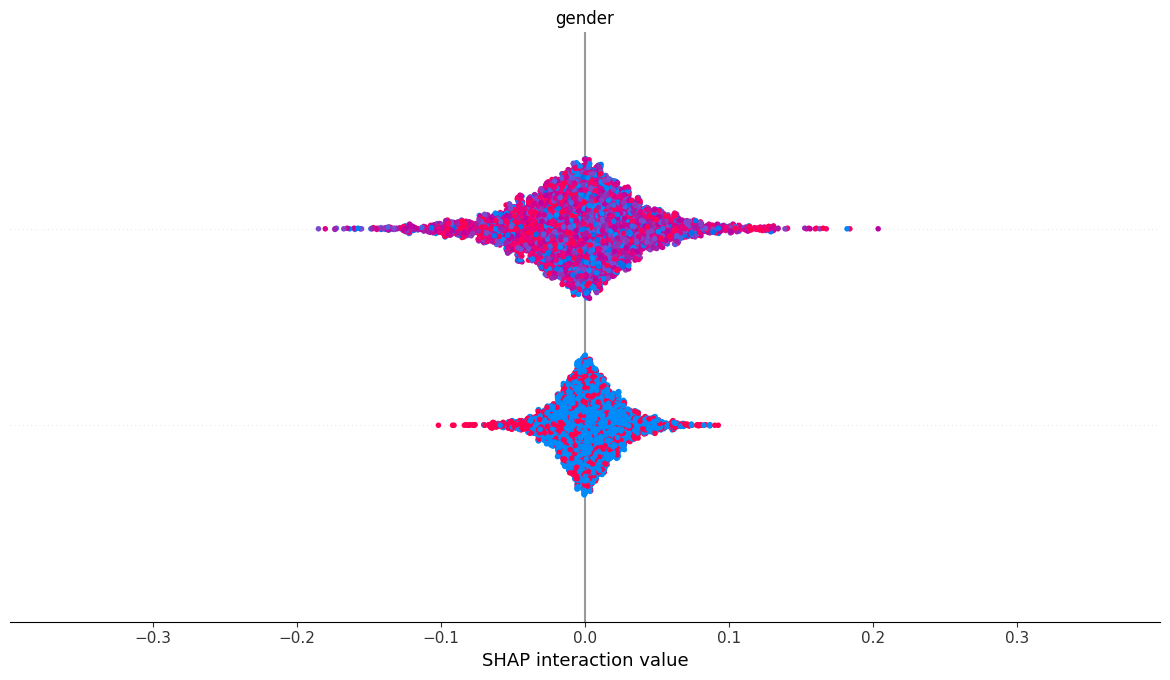


 Selected Features: ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'active']


In [ ]:
# Step 4: Feature Selection Using SHAP & RFE (Fixed)

# Define Features and Target
X = df.drop(columns=['cardio'])
y = df['cardio']

# Sample a smaller subset for feature selection (5000 rows)
df_sample = df.sample(n=5000, random_state=42)

X_sample = df_sample.drop(columns=['cardio'])
y_sample = df_sample['cardio']

# Train Random Forest Model on the smaller sample
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_sample, y_sample)

# Apply SHAP for Feature Importance (Fix: Use same dataset)
explainer = shap.Explainer(rf, X_sample)
shap_values = explainer(X_sample, check_additivity=False)  # Fix: Disable additivity check

# Plot SHAP Feature Importance
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_sample)

# Apply Recursive Feature Elimination (RFE) on the same dataset
selector = RFECV(rf, step=2, cv=3)  # Step=2 for faster execution
selector.fit(X_sample, y_sample)

# Keep only selected features
X_selected = X.iloc[:, selector.support_]
print("\n Selected Features:", list(X_selected.columns))



 Model: Decision Tree
              precision    recall  f1-score   support

           0       0.64      0.66      0.65      6957
           1       0.64      0.62      0.63      6722

    accuracy                           0.64     13679
   macro avg       0.64      0.64      0.64     13679
weighted avg       0.64      0.64      0.64     13679



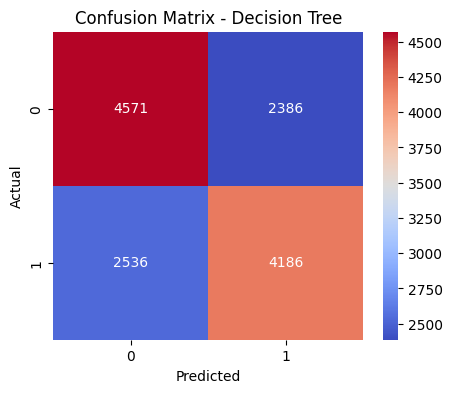

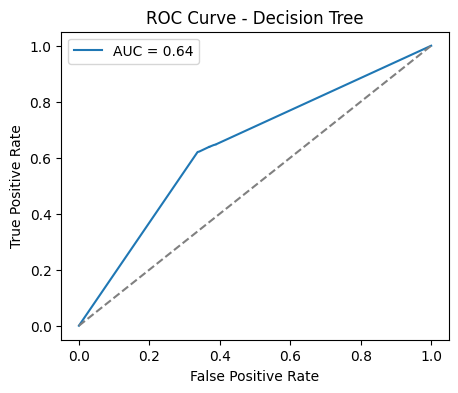


 Model: Random Forest
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      6957
           1       0.70      0.70      0.70      6722

    accuracy                           0.70     13679
   macro avg       0.70      0.70      0.70     13679
weighted avg       0.70      0.70      0.70     13679



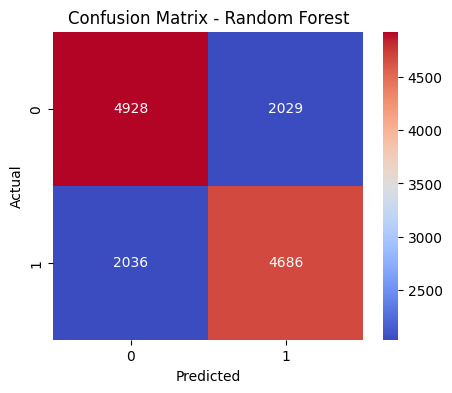

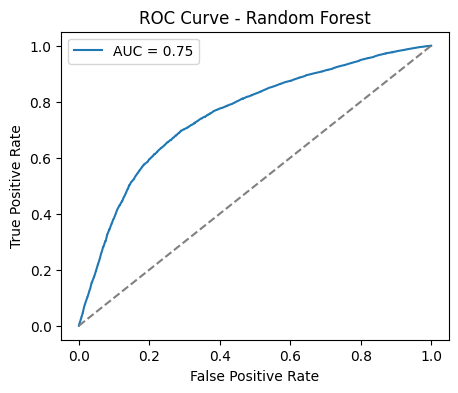


 Model: SVM
              precision    recall  f1-score   support

           0       0.70      0.80      0.74      6957
           1       0.76      0.64      0.69      6722

    accuracy                           0.72     13679
   macro avg       0.73      0.72      0.72     13679
weighted avg       0.73      0.72      0.72     13679



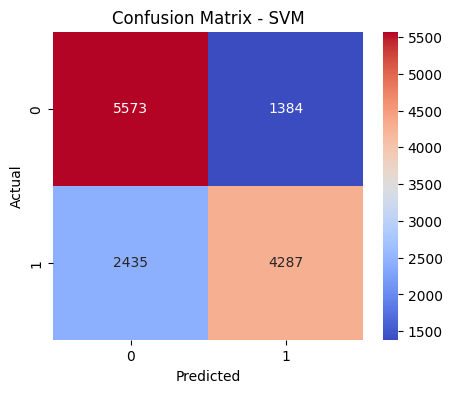

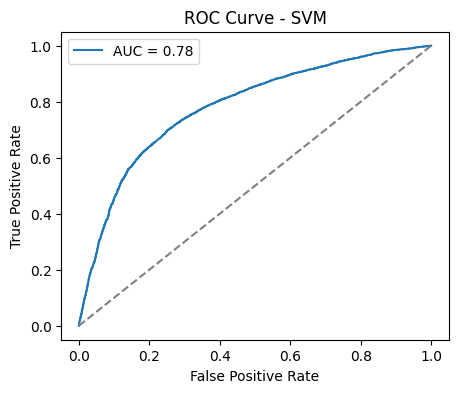

In [ ]:
# Step 5: Train & Evaluate Machine Learning Models
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="linear", probability=True, random_state=42)
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Print classification report
    print(f"\n Model: {name}")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="coolwarm")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_score = auc(fpr, tpr)

        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.title(f"ROC Curve - {name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

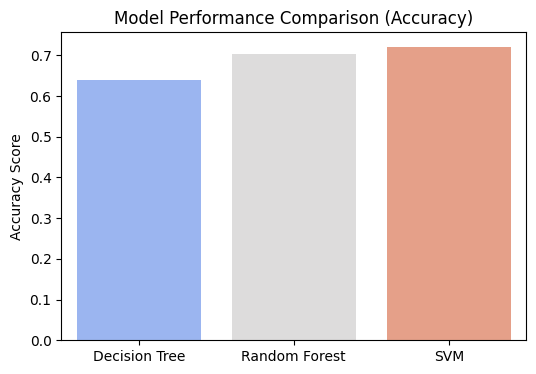

In [ ]:
# Step 6: Model Performance Comparison
# Compare Model Performance
accuracies = {name: accuracy_score(y_test, model.predict(X_test)) for name, model in models.items()}

# Plot model accuracies
plt.figure(figsize=(6,4))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette="coolwarm")
plt.title("Model Performance Comparison (Accuracy)")
plt.ylabel("Accuracy Score")
plt.show()


📌 Chi-Square Test for smoke
Chi2 Value: 18.07, p-value: 0.0000


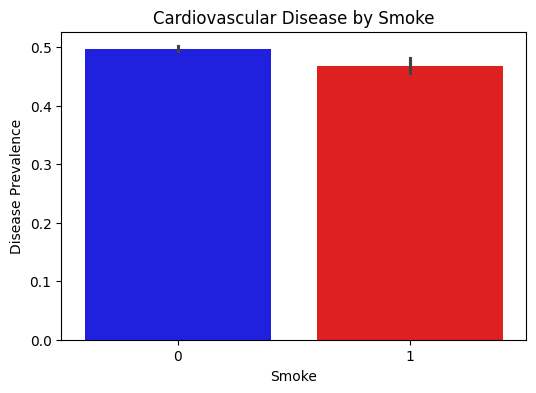


📌 Chi-Square Test for alco
Chi2 Value: 5.37, p-value: 0.0204


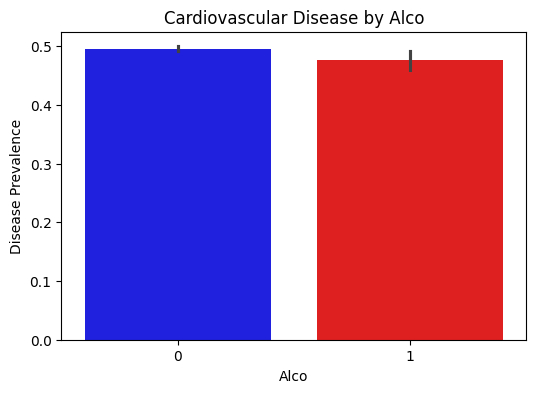


📌 Chi-Square Test for active
Chi2 Value: 97.32, p-value: 0.0000


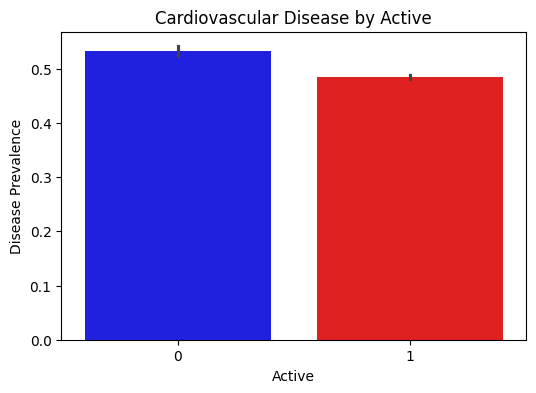

In [ ]:
# Step 7: Statistical Analysis on Lifestyle Factors
# Chi-Square Test for Categorical Variables
for feature in ['smoke', 'alco', 'active']:
    contingency_table = pd.crosstab(df[feature], df['cardio'])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"\n Chi-Square Test for {feature}")
    print(f"Chi2 Value: {chi2:.2f}, p-value: {p:.4f}")

    # Bar Plot
    plt.figure(figsize=(6,4))
    sns.barplot(x=df[feature], y=df['cardio'], palette=['blue', 'red'])
    plt.title(f"Cardiovascular Disease by {feature.capitalize()}")
    plt.xlabel(feature.capitalize())
    plt.ylabel("Disease Prevalence")
    plt.show()